In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy.stats import chi2_contingency
sns.set(palette="muted", color_codes=True)

In [15]:
df = pd.read_csv(".\数据集\TrainingData.csv", header=0)
df

,Quote_Id,Quote_Date,Quote_Flag,Field_info1,Field_info2,Field_info3,Field_info4,Coverage_info1,Coverage_info2,Coverage_info3,...,Property_info1,Property_info2,Property_info3,Property_info4,Property_info5,Geographic_info1,Geographic_info2,Geographic_info3,Geographic_info4,Geographic_info5
0,2,14/5/14,0,B,0.9153,935,N,5,2,D,...,N,0,D,1,6,2,13,-1,N,CA
1,3,19/6/13,0,J,0.9691,"1,165",N,5,22,F,...,N,0,D,1,8,14,7,-1,N,TX
2,6,6/2/15,0,B,0.9153,935,N,6,22,D,...,N,0,D,1,11,2,12,-1,N,CA
3,9,15/10/14,0,J,0.8793,"1,113",N,1,22,F,...,N,0,O,0,1,14,6,-1,N,TX
4,10,30/3/15,1,F,1.0101,548,N,13,22,E,...,N,0,R,1,25,4,22,-1,N,NJ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62575,104296,28/6/13,0,F,0.9919,564,N,4,25,J,...,N,0,R,1,16,4,17,-1,N,NJ
62576,104297,25/1/14,0,F,0.9838,548,N,13,2,E,...,N,0,R,1,18,4,19,-1,N,NJ
62577,104299,24/1/14,0,B,0.9403,935,N,7,22,E,...,N,0,D,0,24,2,8,-1,N,CA
62578,104300,7/12/14,0,J,0.8870,"1,113",N,15,25,G,...,N,0,J,1,23,14,5,-1,N,TX


## 问题
问题1：30个属性，每一个属性，是类别型的还是数值型。  
  
有些是一个数值，但实际代表类别，有些被错误划分成类别型，但实际是数值型 
  
问题2：

<AxesSubplot:>

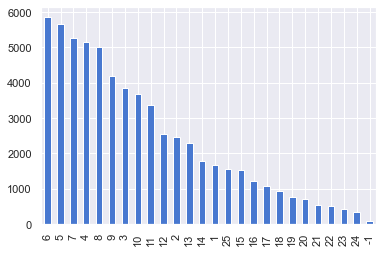

In [19]:
df['Coverage_info2'].value_counts().plot.bar()

In [20]:
df['Coverage_info2'] = df['Coverage_info2'].astype('object')
df['Coverage_info2'].dtype

dtype('O')

## 问题2：处理缺失值
无论连续还是离散的；缺失值比较少，可以选择直接删除含有缺失值的行  
连续型缺失值：填充的时候，填充为0，callable充为平均值或中位数，或自选择填充值
  
离散型缺失值：填充为none，填众数 对于类别严重失衡的，谨慎填充
特殊处理方法：重新分箱处理，对属性取值进行重新合并，分箱之后再用众数填充


In [21]:
#找到A中包含缺失值的变量
A=df.select_dtypes(include='object').copy()
Anull=A.isnull().sum()[A.isnull().sum()>0]
Anull

Personal_info1      23
Property_info1      16
Geographic_info4     1
dtype: int64

In [25]:
A.dropna(axis=0,subset = Anull.index,inplace = True)
A.isnull().sum()

Quote_Date          0
Field_info1         0
Field_info3         0
Field_info4         0
Coverage_info2      0
Coverage_info3      0
Sales_info4         0
Personal_info1      0
Personal_info3      0
Property_info1      0
Property_info3      0
Geographic_info4    0
Geographic_info5    0
dtype: int64

In [26]:
B=df.select_dtypes(include=['int64','float']).copy()
B.isnull().sum()

Quote_Id                0
Quote_Flag              0
Field_info2             0
Coverage_info1          0
Sales_info1             0
Sales_info2             0
Sales_info3             0
Sales_info5             0
Personal_info2          0
Personal_info4          0
Personal_info5      29788
Property_info2          0
Property_info4          0
Property_info5          0
Geographic_info1        0
Geographic_info2        0
Geographic_info3        0
dtype: int64

In [27]:
B['Personal_info5'].value_counts()

2.0    32409
1.0      364
5.0       18
3.0        1
Name: Personal_info5, dtype: int64

In [28]:
B.loc[B['Personal_info5'].notnull(),'Personal_info5']=1
B.loc[:,'Personal_info5'].fillna(0,inplace=True)
B['Personal_info5'].value_counts()

1.0    32792
0.0    29788
Name: Personal_info5, dtype: int64

In [29]:
(B==-1).sum()

Quote_Id                0
Quote_Flag              0
Field_info2             0
Coverage_info1         86
Sales_info1             0
Sales_info2             0
Sales_info3             0
Sales_info5             0
Personal_info2      13184
Personal_info4          0
Personal_info5          0
Property_info2          0
Property_info4          0
Property_info5          5
Geographic_info1        1
Geographic_info2        1
Geographic_info3    61064
dtype: int64

In [30]:
cond=(B.Coverage_info1!=-1)&(B.Property_info5!=-1)&(B.Geographic_info1!=-1)&(B.Geographic_info2!=-1)
B1=B[cond]
B1

,Quote_Id,Quote_Flag,Field_info2,Coverage_info1,Sales_info1,Sales_info2,Sales_info3,Sales_info5,Personal_info2,Personal_info4,Personal_info5,Property_info2,Property_info4,Property_info5,Geographic_info1,Geographic_info2,Geographic_info3
0,2,0,0.9153,5,1,5,11,55101,-1,0,1.0,0,1,6,2,13,-1
1,3,0,0.9691,5,1,5,1,5476,-1,0,0.0,0,1,8,14,7,-1
2,6,0,0.9153,6,1,5,11,59655,18,0,1.0,0,1,11,2,12,-1
3,9,0,0.8793,1,1,5,11,6943,5,0,1.0,0,0,1,14,6,-1
4,10,1,1.0101,13,1,3,20,61148,6,0,0.0,0,1,25,4,22,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62575,104296,0,0.9919,4,0,5,17,38162,7,0,0.0,0,1,16,4,17,-1
62576,104297,0,0.9838,13,0,5,20,35716,23,0,1.0,0,1,18,4,19,-1
62577,104299,0,0.9403,7,1,4,7,16738,5,0,1.0,0,0,24,2,8,-1
62578,104300,0,0.8870,15,1,4,11,4899,-1,0,0.0,0,1,23,14,5,-1


In [31]:
B1.drop('Geographic_info3', axis = 1, inplace = True)
B1.head()

C:\Users\17630\AppData\Roaming\Python\Python39\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Quote_Id,Quote_Flag,Field_info2,Coverage_info1,Sales_info1,Sales_info2,Sales_info3,Sales_info5,Personal_info2,Personal_info4,Personal_info5,Property_info2,Property_info4,Property_info5,Geographic_info1,Geographic_info2
0,2,0,0.9153,5,1,5,11,55101,-1,0,1.0,0,1,6,2,13
1,3,0,0.9691,5,1,5,1,5476,-1,0,0.0,0,1,8,14,7
2,6,0,0.9153,6,1,5,11,59655,18,0,1.0,0,1,11,2,12
3,9,0,0.8793,1,1,5,11,6943,5,0,1.0,0,0,1,14,6
4,10,1,1.0101,13,1,3,20,61148,6,0,0.0,0,1,25,4,22


<AxesSubplot:>

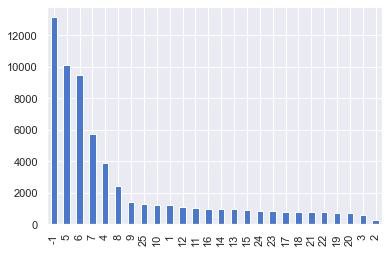

In [33]:
B1['Personal_info2'].value_counts().plot.bar()

In [12]:
B1.loc[B1['Personal_info2']==-1,'Personal_info2']=0
B1['Personal_info2'].value_counts()

C:\Users\17630\AppData\Roaming\Python\Python39\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


0     13148
5     10127
6      9437
7      5730
4      3856
8      2392
9      1409
25     1253
10     1206
1      1188
12     1060
11     1013
16      937
14      934
13      929
15      894
24      848
23      844
17      769
18      756
21      756
22      752
19      719
20      674
3       589
2       273
Name: Personal_info2, dtype: int64

In [13]:
print((B1==-1).sum())
print('----------------------')
print(B1.isnull().sum())

Quote_Id            0
Quote_Flag          0
Field_info2         0
Coverage_info1      0
Coverage_info2      0
Sales_info1         0
Sales_info2         0
Sales_info3         0
Sales_info5         0
Personal_info2      0
Personal_info4      0
Personal_info5      0
Property_info2      0
Property_info4      0
Property_info5      0
Geographic_info1    0
Geographic_info2    0
dtype: int64
----------------------
Quote_Id            0
Quote_Flag          0
Field_info2         0
Coverage_info1      0
Coverage_info2      0
Sales_info1         0
Sales_info2         0
Sales_info3         0
Sales_info5         0
Personal_info2      0
Personal_info4      0
Personal_info5      0
Property_info2      0
Property_info4      0
Property_info5      0
Geographic_info1    0
Geographic_info2    0
dtype: int64
